**Disclaimer:** When I created the first version of this notebook, I copied a lot of boilerplate code from another project. I somehow missed that `KFold` doesn't make sense to use with this dataset. Even worse, I set `shuffle=True`. This introduced leakage into the pipeline, meaning the model used future data to train and was validated on past data. Despite this obvious mistake, the code scored high both on the public leaderboard and in cross-validation. This is an obvious error and indicates heavy overfitting to the public leaderboard. Therefore, I advise against using the code or output from notebook versions 8 and below (especially version 1).

# Configs and Imports

In [1]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from optuna.samplers import TPESampler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.base import clone
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna

warnings.filterwarnings('ignore')

In [2]:
N_FOLDS = 5
N_REPEATS = 1
SEED = 27

# Loading and Processing The Datasets

In [3]:
train = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train.csv')
test = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test.csv')

test_ids = test.id.values

train.shape, test.shape

((7340, 18), (397, 8))

In [4]:
missing_cols_in_test = [
    'shutdown',
    'mini_shutdown',
    'blackout',
    'mov_change',
    'frankfurt_shutdown',
    'precipitation',
    'snow',
    'user_activity_1',
    'user_activity_2'
]

train = train.drop(missing_cols_in_test, axis=1, errors='ignore')
train = train.sort_values("date").reset_index(drop=True)
train.shape, test.shape

((7340, 9), (397, 8))

In [5]:
train

,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,Prague_1_2020-12-05
1,Prague_2,2020-12-05,4154.0,NaN,0,0,0,0,Prague_2_2020-12-05
2,Prague_3,2020-12-05,4091.0,NaN,0,0,0,0,Prague_3_2020-12-05
3,Budapest_1,2020-12-05,4623.0,NaN,0,0,0,0,Budapest_1_2020-12-05
4,Brno_1,2020-12-05,6447.0,NaN,0,0,0,0,Brno_1_2020-12-05
...,...,...,...,...,...,...,...,...,...
7335,Brno_1,2024-03-15,10777.0,NaN,0,0,0,0,Brno_1_2024-03-15
7336,Prague_3,2024-03-15,6408.0,NaN,0,0,0,0,Prague_3_2024-03-15
7337,Prague_1,2024-03-15,11917.0,NaN,0,0,0,0,Prague_1_2024-03-15
7338,Prague_2,2024-03-15,7140.0,NaN,0,0,0,0,Prague_2_2024-03-15


In [6]:
test

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16
1,Prague_1,2024-03-17,NaN,0,0,0,0,Prague_1_2024-03-17
2,Prague_1,2024-03-18,NaN,0,0,0,0,Prague_1_2024-03-18
3,Prague_1,2024-03-19,NaN,0,0,0,0,Prague_1_2024-03-19
4,Prague_1,2024-03-20,NaN,0,0,0,0,Prague_1_2024-03-20
...,...,...,...,...,...,...,...,...
392,Budapest_1,2024-05-11,NaN,0,0,0,0,Budapest_1_2024-05-11
393,Budapest_1,2024-05-12,NaN,0,0,0,0,Budapest_1_2024-05-12
394,Budapest_1,2024-05-13,NaN,0,0,0,0,Budapest_1_2024-05-13
395,Budapest_1,2024-05-14,NaN,0,0,0,0,Budapest_1_2024-05-14


In [7]:
for df in [train, test]:
    df['holiday_name'] = df['holiday_name'].fillna('').astype('category')
    df['warehouse'] = df['warehouse'].astype('category')
    
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['season'] = (df['month'] % 12 + 3) // 3
    df['season'] = df['season'].astype(int)
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['day_before_holiday'] = df['holiday'].shift().fillna(0)
    df['day_after_holiday'] = df['holiday'].shift(-1).fillna(0)
    df['day_before_school_holiday'] = df['school_holidays'].shift().fillna(0)
    df['day_after_school_holiday'] = df['school_holidays'].shift(-1).fillna(0)
    df['day_before_winter_school_holiday'] = df['winter_school_holidays'].shift().fillna(0)
    df['day_after_winter_school_holiday'] = df['winter_school_holidays'].shift(-1).fillna(0)
    df['holiday_and_shops_closed'] = df['holiday'] * df['shops_closed']
    df['week_before_holiday'] = df['holiday'].shift(-7).rolling(window=7, min_periods=1).sum().shift(1).fillna(0).apply(lambda x: 1 if x > 0 else 0)


cat_features = [col for col in train.columns if train[col].dtype.name == 'category']

train.shape, test.shape

((7340, 26), (397, 25))

In [8]:
train

,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id,year,...,season,is_weekend,day_before_holiday,day_after_holiday,day_before_school_holiday,day_after_school_holiday,day_before_winter_school_holiday,day_after_winter_school_holiday,holiday_and_shops_closed,week_before_holiday
0,Prague_1,2020-12-05,6895.0,,0,0,0,0,Prague_1_2020-12-05,2020,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,Prague_2,2020-12-05,4154.0,,0,0,0,0,Prague_2_2020-12-05,2020,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,Prague_3,2020-12-05,4091.0,,0,0,0,0,Prague_3_2020-12-05,2020,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,Budapest_1,2020-12-05,4623.0,,0,0,0,0,Budapest_1_2020-12-05,2020,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,Brno_1,2020-12-05,6447.0,,0,0,0,0,Brno_1_2020-12-05,2020,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7335,Brno_1,2024-03-15,10777.0,,0,0,0,0,Brno_1_2024-03-15,2024,...,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
7336,Prague_3,2024-03-15,6408.0,,0,0,0,0,Prague_3_2024-03-15,2024,...,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
7337,Prague_1,2024-03-15,11917.0,,0,0,0,0,Prague_1_2024-03-15,2024,...,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
7338,Prague_2,2024-03-15,7140.0,,0,0,0,0,Prague_2_2024-03-15,2024,...,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [9]:
test

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id,year,month,...,season,is_weekend,day_before_holiday,day_after_holiday,day_before_school_holiday,day_after_school_holiday,day_before_winter_school_holiday,day_after_winter_school_holiday,holiday_and_shops_closed,week_before_holiday
0,Prague_1,2024-03-16,,0,0,0,0,Prague_1_2024-03-16,2024,3,...,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,Prague_1,2024-03-17,,0,0,0,0,Prague_1_2024-03-17,2024,3,...,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,Prague_1,2024-03-18,,0,0,0,0,Prague_1_2024-03-18,2024,3,...,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,Prague_1,2024-03-19,,0,0,0,0,Prague_1_2024-03-19,2024,3,...,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,Prague_1,2024-03-20,,0,0,0,0,Prague_1_2024-03-20,2024,3,...,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,Budapest_1,2024-05-11,,0,0,0,0,Budapest_1_2024-05-11,2024,5,...,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
393,Budapest_1,2024-05-12,,0,0,0,0,Budapest_1_2024-05-12,2024,5,...,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
394,Budapest_1,2024-05-13,,0,0,0,0,Budapest_1_2024-05-13,2024,5,...,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
395,Budapest_1,2024-05-14,,0,0,0,0,Budapest_1_2024-05-14,2024,5,...,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [10]:
X_train = train.drop(['date', 'orders', 'id'], axis=1)
y_train = train['orders']

X_test = test.drop(['date', 'id'], axis=1)

# Training Base Models

In [11]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS, n_repeats=N_REPEATS):
        self.model = model
        self.n_folds = n_folds
        self.n_repeats = n_repeats

    def fit(self, X, y):
        print(f'Training {self.model.__class__.__name__}')
        
        tss = TimeSeriesSplit(n_splits=self.n_folds).split(X, y)
        
        start_idx = None
        scores = []
        oof_preds = np.zeros(len(X), dtype=float)
        for fold_idx, (train_idx, val_idx) in enumerate(tss):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            if start_idx is None:
                start_idx = val_idx[0]
            
            y_pred = np.zeros_like(y_val, dtype=float)
            for i in range(self.n_repeats):
                m = clone(self.model)
                if self.n_repeats > 1:
                    m.set_params(random_state=i)
                m.fit(X_train, y_train)
                y_pred += m.predict(X_val)
                
            y_pred /= self.n_repeats
            
            score = mean_absolute_percentage_error(y_val, y_pred)
            scores.append(score)
            
            print(f'--- Fold {fold_idx + 1} - MAPE: {score:.6f}')
            
            oof_preds[val_idx] = y_pred
            
        print(f'\n------ MAPE: {np.mean(scores):.6f} ± {np.std(scores):.6f}\n\n')
            
        return m, scores, oof_preds, start_idx
        
    def fit_predict(self, X, y, X_test):
        y_pred = np.zeros(len(X_test), dtype=float)
        for i in range(self.n_repeats):
            m = clone(self.model)
            if self.n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(X, y)
            y_pred += m.predict(X_test)
        y_pred /= self.n_repeats
        return y_pred

In [12]:
xgb_params = {
    "booster": "gbtree",
    "colsample_bylevel": 0.9673859327785632,
    "colsample_bynode": 0.4923751425658328,
    "colsample_bytree": 0.912934729761709,
    "enable_categorical": True,
    "gamma": 6.370448095325031,
    "grow_policy": "lossguide",
    "learning_rate": 0.012256291098871963,
    "max_depth": 44,
    "min_child_weight": 6.020222516598196,
    "n_estimators": 3968,
    "n_jobs": -1,
    "random_state": SEED,
    "reg_alpha": 6.594466467943319,
    "reg_lambda": 3.668453209568534,
    "subsample": 0.8380164729493292,
    "verbosity": 0
}

cb_params = {
    "bootstrap_type": "MVS",
    "border_count": 236,
    "colsample_bylevel": 0.9895796854882428,
    "depth": 6,
    "grow_policy": "SymmetricTree",
    "iterations": 4727,
    "l2_leaf_reg": 8.243537067932515,
    "loss_function": "Quantile",
    "min_data_in_leaf": 41,
    "random_state": SEED,
    "random_strength": 0.8499226947970046,
    "subsample": 0.7467840216120686,
    "thread_count": -1,
    "verbose": False
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.9547441579422116,
    "learning_rate": 0.04406871820205758,
    "min_child_samples": 8,
    "min_child_weight": 0.5163384032966228,
    "min_split_gain": 0.18807271127987724,
    "n_estimators": 663,
    "n_jobs": -1,
    "num_leaves": 48,
    "random_state": SEED,
    "reg_alpha": 5.4660768249665646,
    "reg_lambda": 5.974261145462608,
    "subsample": 0.039552743069246055,
    "verbose": -1
}

In [13]:
xgb_model = XGBRegressor(**xgb_params)
xgb_trainer = Trainer(xgb_model)
xgb_model, xgb_scores, xgb_oof_preds, idx = xgb_trainer.fit(X_train, y_train)
xgb_test_preds = xgb_trainer.fit_predict(X_train, y_train, X_test)

Training XGBRegressor
--- Fold 1 - MAPE: 0.292446
--- Fold 2 - MAPE: 0.167854
--- Fold 3 - MAPE: 0.132122
--- Fold 4 - MAPE: 0.070603
--- Fold 5 - MAPE: 0.132829

------ MAPE: 0.159171 ± 0.073631




In [14]:
cb_model = CatBoostRegressor(**cb_params, cat_features=cat_features)
cb_trainer = Trainer(cb_model)
cb_model, cb_scores, cb_oof_preds, idx = cb_trainer.fit(X_train, y_train)
cb_test_preds = cb_trainer.fit_predict(X_train, y_train, X_test)

Training CatBoostRegressor
--- Fold 1 - MAPE: 0.216870
--- Fold 2 - MAPE: 0.078001
--- Fold 3 - MAPE: 0.200811
--- Fold 4 - MAPE: 0.069069
--- Fold 5 - MAPE: 0.139621

------ MAPE: 0.140874 ± 0.060792




In [15]:
lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
lgbm_model, lgbm_scores, lgbm_oof_preds, idx = lgbm_trainer.fit(X_train, y_train)
lgbm_test_preds = lgbm_trainer.fit_predict(X_train, y_train, X_test)

Training LGBMRegressor
--- Fold 1 - MAPE: 0.287395
--- Fold 2 - MAPE: 0.156887
--- Fold 3 - MAPE: 0.066675
--- Fold 4 - MAPE: 0.068188
--- Fold 5 - MAPE: 0.130185

------ MAPE: 0.141866 ± 0.080775




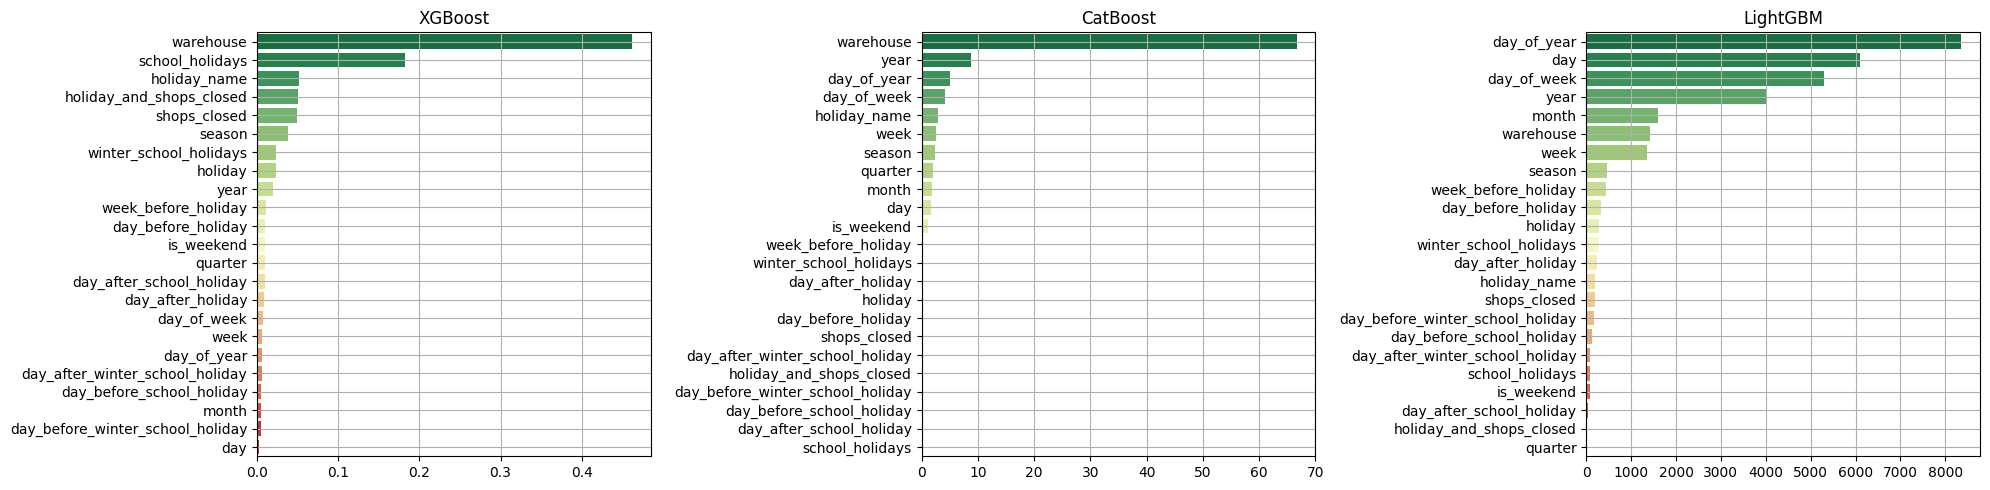

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

palette = sns.color_palette("RdYlGn_r", len(X_train.columns))

xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(y=xgb_importances.index, x=xgb_importances.values, orient='h', ax=axs[0], palette=palette)
axs[0].set_title('XGBoost')
axs[0].grid(True)

cb_importances = pd.Series(cb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(y=cb_importances.index, x=cb_importances.values, orient='h', ax=axs[1], palette=palette)
axs[1].set_title('CatBoost')
axs[1].grid(True)

lgbm_importances = pd.Series(lgbm_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(y=lgbm_importances.index, x=lgbm_importances.values, orient='h', ax=axs[2], palette=palette)
axs[2].set_title('LightGBM')
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Ensemble

In [17]:
_X_train = pd.DataFrame(np.column_stack([
    xgb_oof_preds[idx:],
    cb_oof_preds[idx:], 
    lgbm_oof_preds[idx:]
]))

_X_test = pd.DataFrame(np.column_stack([
    xgb_test_preds,
    cb_test_preds,
    lgbm_test_preds
]))

In [18]:
_X_train

,0,1,2
0,4126.121094,4083.414073,4205.842333
1,3734.127197,3690.785285,3755.203796
2,4400.008789,4382.695419,4447.626682
3,6612.355957,6427.137986,6756.510922
4,4161.398438,4094.661484,4228.749495
...,...,...,...
6110,8448.157227,8446.672810,8517.408987
6111,5538.813965,5575.329068,5700.954171
6112,10195.900391,9172.826657,10314.143165
6113,6044.877441,6037.659362,6204.198895


In [19]:
_X_test

,0,1,2
0,10238.760742,10437.088701,10398.312910
1,10097.979492,10175.746828,10229.001476
2,9772.933594,9818.788855,9720.895257
3,9536.712891,9495.167131,9537.669428
4,9439.211914,9504.925189,9504.928770
...,...,...,...
392,6878.000000,6878.620517,6959.884631
393,6348.752441,6410.313809,6488.771565
394,6312.319824,6438.568555,6493.089752
395,6467.357910,6416.976069,6493.927390


In [20]:
ridge_model = Ridge()
ridge_trainer = Trainer(ridge_model, n_repeats=1)
ridge_model, ridge_scores, ridge_oof_preds, _idx = ridge_trainer.fit(_X_train, y_train[idx:])
ridge_test_preds = ridge_trainer.fit_predict(_X_train, y_train[idx:], _X_test)

Training Ridge
--- Fold 1 - MAPE: 0.270231
--- Fold 2 - MAPE: 0.281736
--- Fold 3 - MAPE: 0.127407
--- Fold 4 - MAPE: 0.062095
--- Fold 5 - MAPE: 0.122200

------ MAPE: 0.172734 ± 0.087449




In [21]:
lasso_model = Lasso()
lasso_trainer = Trainer(lasso_model, n_repeats=1)
lasso_model, lasso_scores, lasso_oof_preds, _idx = lasso_trainer.fit(_X_train, y_train[idx:])
lasso_test_preds = lasso_trainer.fit_predict(_X_train, y_train[idx:], _X_test)

Training Lasso
--- Fold 1 - MAPE: 0.270232
--- Fold 2 - MAPE: 0.281734
--- Fold 3 - MAPE: 0.127406
--- Fold 4 - MAPE: 0.062095
--- Fold 5 - MAPE: 0.122200

------ MAPE: 0.172734 ± 0.087448




In [22]:
ridge_cv_model = RidgeCV()
ridge_cv_trainer = Trainer(ridge_cv_model, n_repeats=1)
ridge_cv_model, ridge_cv_scores, ridge_cv_oof_preds, _idx = ridge_cv_trainer.fit(_X_train, y_train[idx:])
ridge_cv_test_preds = ridge_cv_trainer.fit_predict(_X_train, y_train[idx:], _X_test)

Training RidgeCV
--- Fold 1 - MAPE: 0.270231
--- Fold 2 - MAPE: 0.281736
--- Fold 3 - MAPE: 0.127406
--- Fold 4 - MAPE: 0.062096
--- Fold 5 - MAPE: 0.122200

------ MAPE: 0.172734 ± 0.087449




In [23]:
lasso_cv_model = LassoCV()
lasso_cv_trainer = Trainer(lasso_cv_model, n_repeats=1)
lasso_cv_model, lasso_cv_scores, lasso_cv_oof_preds, _idx = lasso_cv_trainer.fit(_X_train, y_train[idx:])
lasso_cv_test_preds = lasso_cv_trainer.fit_predict(_X_train, y_train[idx:], _X_test)

Training LassoCV
--- Fold 1 - MAPE: 0.269777
--- Fold 2 - MAPE: 0.215129
--- Fold 3 - MAPE: 0.116770
--- Fold 4 - MAPE: 0.060524
--- Fold 5 - MAPE: 0.121959

------ MAPE: 0.156832 ± 0.075168




In [24]:
oof_preds = {
    "XGBoost": xgb_oof_preds[idx:],
    "CatBoost": cb_oof_preds[idx:],
    "LightGBM": lgbm_oof_preds[idx:],
}

def objective(trial):
    xgb_weight = trial.suggest_float('xgb_weight', 0.0, 1.0)
    cb_weight = trial.suggest_float('cb_weight', 0.0, 1.0)
    lgbm_weight = trial.suggest_float('lgbm_weight', 0.0, 1.0)

    weights = [
        xgb_weight, 
        cb_weight, 
        lgbm_weight, 
    ]
    weights /= np.sum(weights)

    preds = np.zeros((_X_train.shape[0]))
    for model, weight in zip(oof_preds.keys(), weights):
        preds += oof_preds[model] * weight

    return mean_absolute_percentage_error(y_train[idx:], preds)


sampler = TPESampler(seed=SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=1000)

best_weights = study.best_params
best_weights = [best_weights[f'{model}_weight'] for model in ['xgb', 'cb', 'lgbm']]
best_weights /= np.sum(best_weights)

[I 2024-06-20 14:48:25,782] A new study created in memory with name: no-name-42fd2eaf-ac13-4b56-824c-1e1b4859139d
[I 2024-06-20 14:48:25,789] Trial 0 finished with value: 0.1351255866465682 and parameters: {'xgb_weight': 0.4257214105188958, 'cb_weight': 0.8145837404945526, 'lgbm_weight': 0.7353972901996796}. Best is trial 0 with value: 0.1351255866465682.
[I 2024-06-20 14:48:25,797] Trial 1 finished with value: 0.14061861516883858 and parameters: {'xgb_weight': 0.8680031998797357, 'cb_weight': 0.3833807728726202, 'lgbm_weight': 0.9794566321445206}. Best is trial 0 with value: 0.1351255866465682.
[I 2024-06-20 14:48:25,804] Trial 2 finished with value: 0.14353678499158767 and parameters: {'xgb_weight': 0.8931943467151353, 'cb_weight': 0.20971516975437543, 'lgbm_weight': 0.7418276474127408}. Best is trial 0 with value: 0.1351255866465682.
[I 2024-06-20 14:48:25,810] Trial 3 finished with value: 0.13640209570924478 and parameters: {'xgb_weight': 0.6631433191297429, 'cb_weight': 0.88680146

In [25]:
print(f'Ensemble weights: {best_weights}')

Ensemble weights: [2.15602720e-05 5.63453560e-01 4.36524879e-01]


In [26]:
test_preds = {
    "XGBoost": xgb_test_preds,
    "CatBoost": cb_test_preds,
    "LightGBM": lgbm_test_preds,
}

ensemble_preds = np.zeros((_X_test.shape[0]))
for model, weight in zip(test_preds.keys(), best_weights):
    ensemble_preds += test_preds[model] * weight

# Visualizing The Results

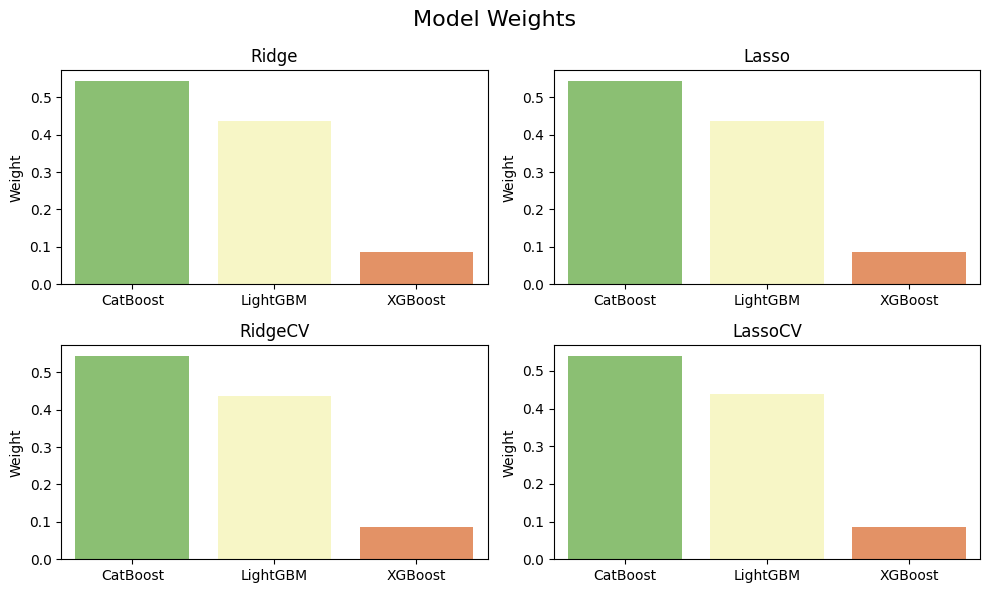

In [27]:
models = [ridge_model, lasso_model, ridge_cv_model, lasso_cv_model]
model_names = [
    'XGBoost',
    'CatBoost',
    'LightGBM',
]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
for ax, model in zip(axes.flatten(), models):
    weights = pd.Series(model.coef_, index=model_names).sort_values(ascending=False)
    sns.barplot(x=weights.index, y=weights.values, ax=ax, palette='RdYlGn_r')
    ax.set_title(f'{model.__class__.__name__}')
    ax.set_ylabel('Weight')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

fig.suptitle('Model Weights', fontsize=16)
plt.tight_layout()
plt.show()

In [28]:
scores = pd.DataFrame({
    xgb_model.__class__.__name__: xgb_scores,
    lgbm_model.__class__.__name__: lgbm_scores,
    cb_model.__class__.__name__: cb_scores,
    ridge_model.__class__.__name__: ridge_scores,
    ridge_cv_model.__class__.__name__: ridge_cv_scores,
    lasso_model.__class__.__name__: lasso_scores,
    lasso_cv_model.__class__.__name__: lasso_cv_scores,
    "Manual Ensemble": np.array([study.best_value] * N_FOLDS)
})

mean_scores = scores.mean().sort_values(ascending=False)
x_min = mean_scores.min() - 0.05 * mean_scores.min()
x_max = mean_scores.max() + 0.05 * mean_scores.max()

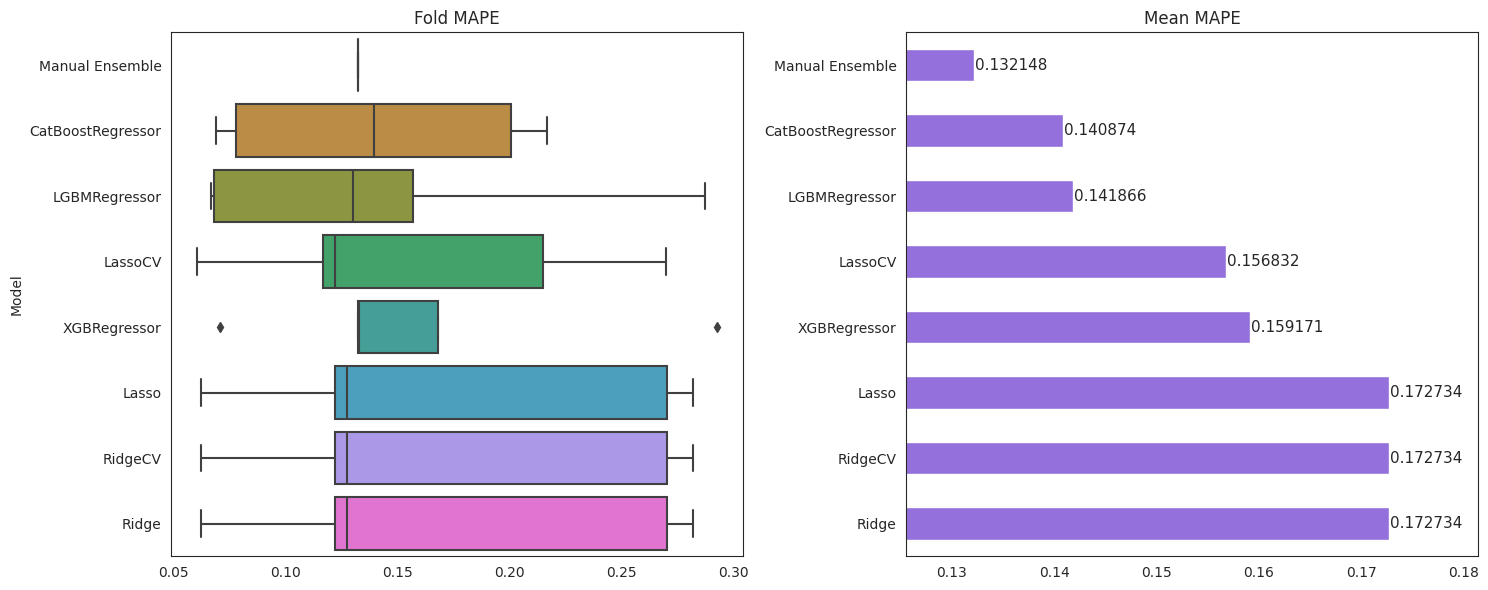

In [29]:
sns.set_style('white')
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(data=scores, orient='h', palette='husl', ax=axes[0], order=scores.mean().sort_values().index.tolist())
axes[0].set_title('Fold MAPE')
axes[0].set_xlabel('')
axes[0].set_ylabel('Model')

mean_scores = scores.mean().sort_values(ascending=False)
mean_scores.plot(kind='barh', ax=axes[1], color='#9370DB')
axes[1].set_title('Mean MAPE')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlim([x_min, x_max])

for i, v in enumerate(mean_scores):
    axes[1].text(v + 1e-4, i, f'{v:.6f}', va='center', fontsize=11)

plt.tight_layout()
plt.show()

In [30]:
submission = pd.DataFrame({'id': test_ids, 'orders': lasso_cv_test_preds})
submission.to_csv(f'lassocv-mape_{np.mean(lasso_cv_scores)}.csv', index=False)
submission.head()

,id,orders
0,Prague_1_2024-03-16,11163.098362
1,Prague_1_2024-03-17,10930.571173
2,Prague_1_2024-03-18,10490.083980
3,Prague_1_2024-03-19,10205.461348
4,Prague_1_2024-03-20,10187.321391


In [31]:
submission = pd.DataFrame({'id': test_ids, 'orders': ensemble_preds})
submission.to_csv(f'ensemble-mape_{study.best_value}.csv', index=False)
submission.head()

,id,orders
0,Prague_1_2024-03-16,10420.157827
1,Prague_1_2024-03-17,10198.992130
2,Prague_1_2024-03-18,9776.054875
3,Prague_1_2024-03-19,9513.721337
4,Prague_1_2024-03-20,9504.925335


In [32]:
submission = submission.rename(columns={'id': 'warehouse'})
submission['date'] = submission['warehouse'].str.split('_').str[2]
submission['warehouse'] = submission['warehouse'].str.split('_').str[:2].str.join('_')

submission['date'] = pd.to_datetime(submission['date'], errors='coerce')
warehouses = submission['warehouse'].unique()
n_warehouses = len(warehouses)

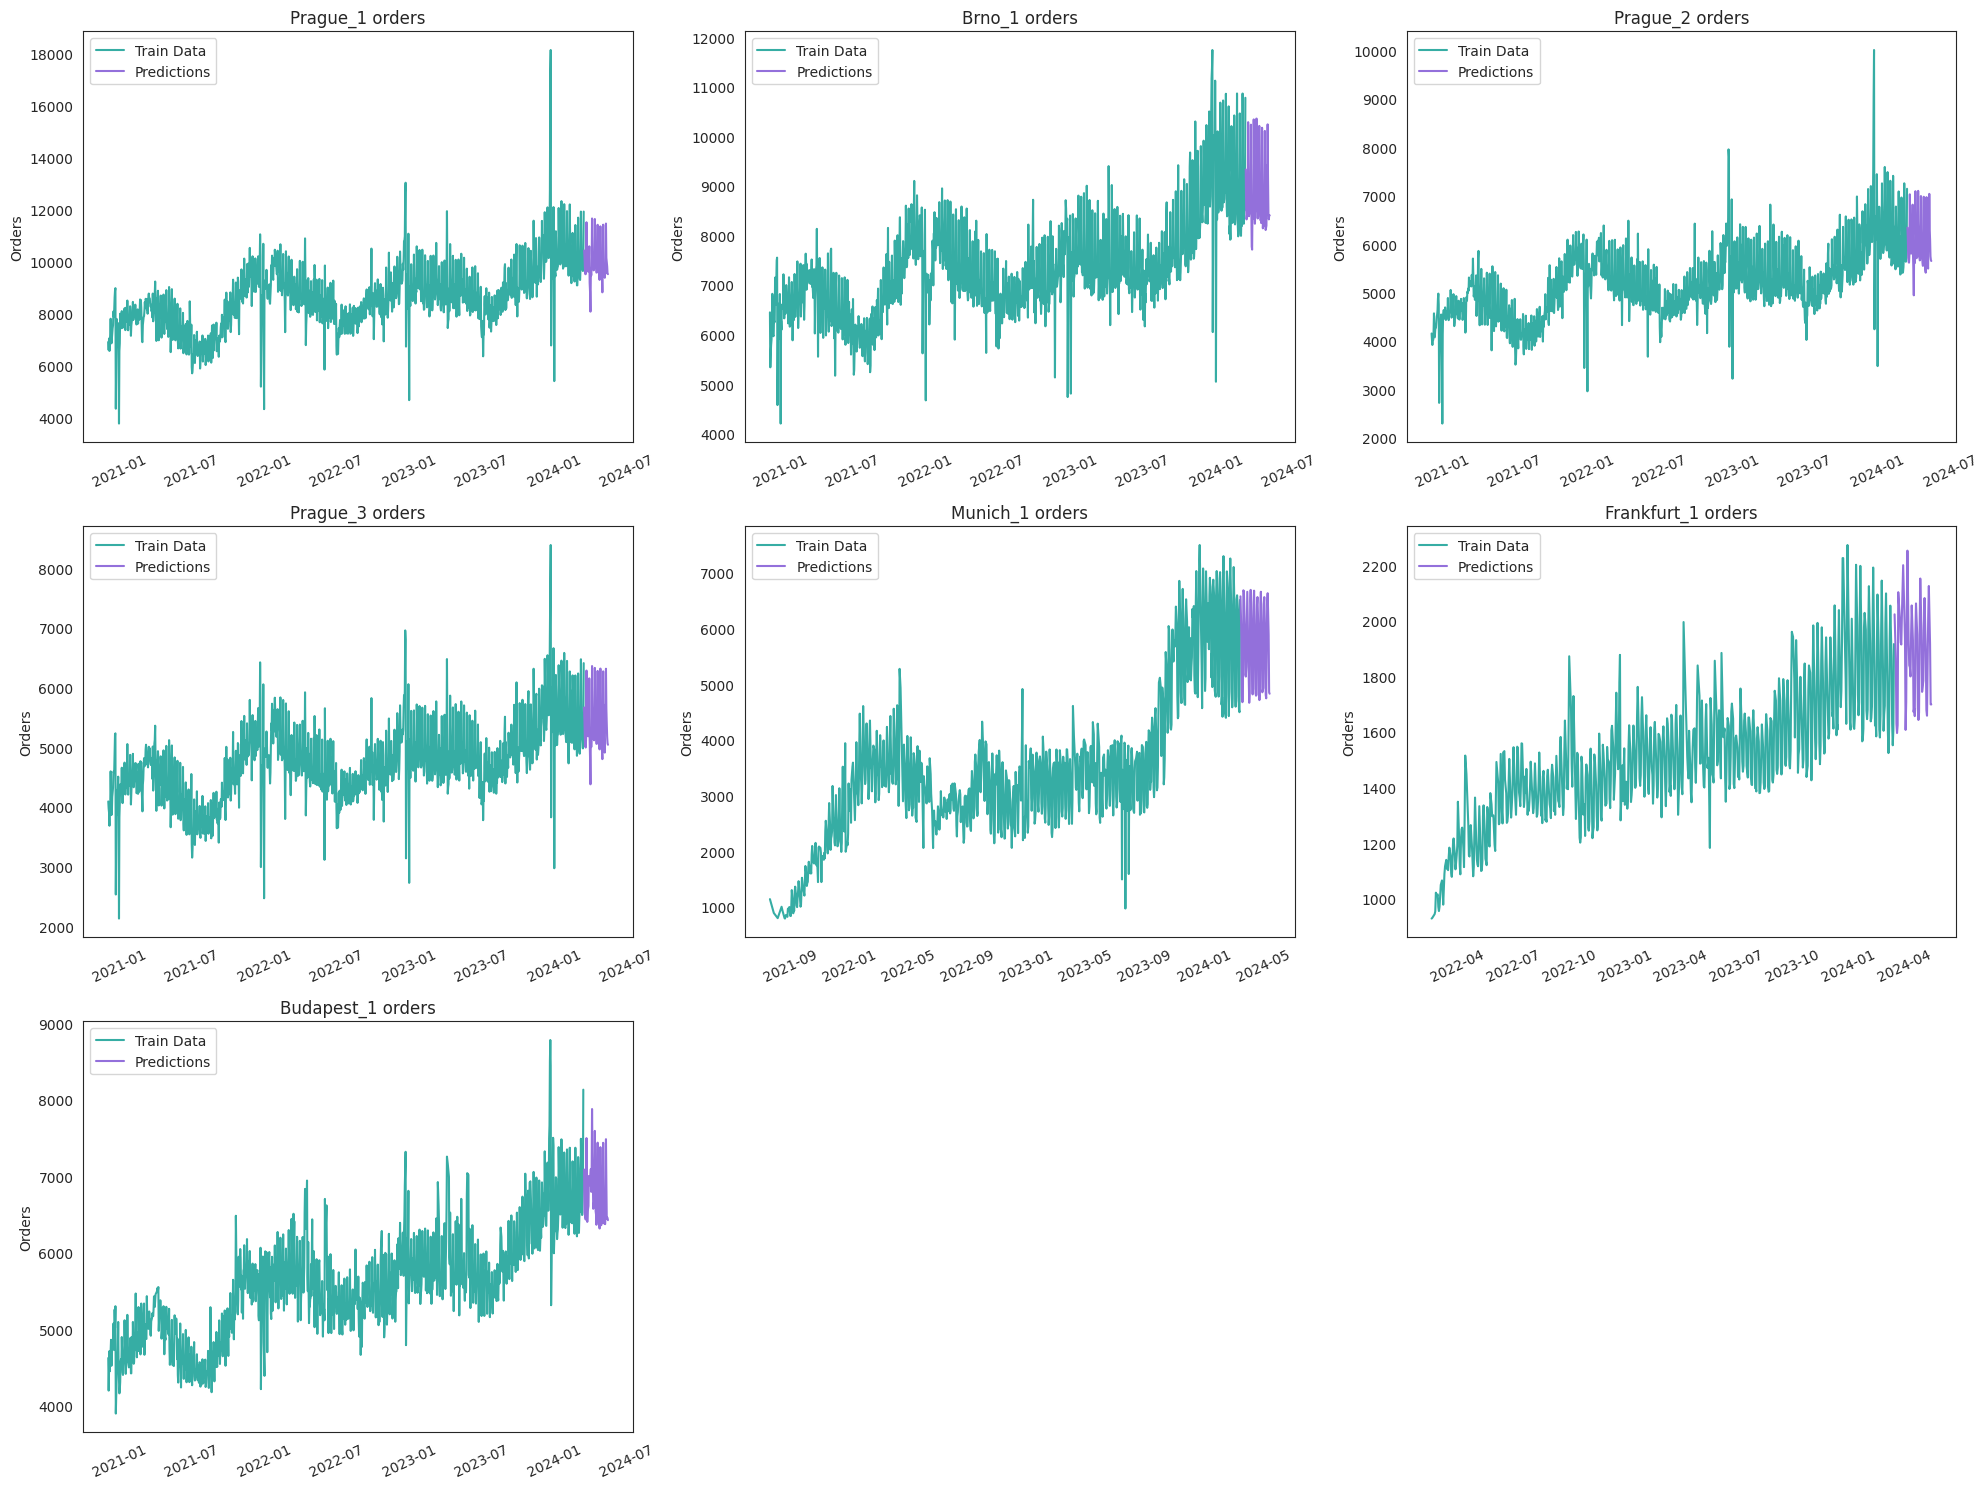

In [33]:
# This plot is based on https://www.kaggle.com/competitions/rohlik-orders-forecasting-challenge/discussion/511783
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

for ax, wh in zip(axes.flatten(), warehouses):
    wh_train = train[train['warehouse'] == wh][['warehouse', 'orders', 'date']].set_index('date')
    wh_submission = submission[submission['warehouse'] == wh][['warehouse', 'orders', 'date']].set_index('date')

    sns.lineplot(x=wh_train.index, y=wh_train['orders'], label='Train Data', ax=ax, color=sns.color_palette('husl')[3])
    sns.lineplot(x=wh_submission.index, y=wh_submission['orders'], label='Predictions', ax=ax, color='#9370DB')

    ax.set_title(f'{wh} orders')
    ax.set_xlabel('')
    ax.set_ylabel('Orders')
    ax.legend()
    ax.tick_params(axis='x', rotation=25)

axes[-1, -1].axis('off')
axes[-1, -2].axis('off')

plt.tight_layout()
plt.show()